# Modelos de Regresion

Utilizando modelos de regresion, buscamos predecir la satisfaccion del cliente y los retrasos en entregas.

In [331]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
from sklearn.model_selection import GridSearchCV

# Abrir CSV
df = pd.read_csv('dataset/cleaned_orders.csv')
df['delivery_delayed'] =  df['delivery_delayed'].astype(int)
df['different_state'] = df['different_state'].astype(int)

# Eliminar algunas variables respuesta de otros modelos
df.drop(columns=['has_comment', 'has_title'], inplace=True)
df = df.dropna()

# Separar en test y train con 30/70 para predicciones de satisfaccion
dftrain, dftest = train_test_split(
    df,
    test_size=0.3,
    stratify=df['review_score'],
    random_state=42
)

# Separar en test y train con 30/70 para predicciones de delivery
dftrain_d, dftest_d = train_test_split(
    df,
    test_size=0.3,
    random_state=42
)

# Eliminar columnas que practicamente nos dan la respuesta
dftrain_d.drop(columns=['estimated_delivery_days', 'delivery_delayed', 'delivery_delta', 'review_score'], inplace=True)
dftest_d.drop(columns=['estimated_delivery_days', 'delivery_delayed', 'delivery_delta', 'review_score'], inplace=True)
dftrain_d.head(15)


delivery_days  ...  payment_type_voucher
48973             16  ...                   0.0
17686             22  ...                   0.0
35797              6  ...                   0.0
51599              6  ...                   0.0
13447             10  ...                   0.0
87458              7  ...                   0.0
45288             15  ...                   0.0
12912              8  ...                   0.0
84024             14  ...                   1.0
51872              9  ...                   0.0
20865             12  ...                   1.0
56840             10  ...                   0.0
54454              6  ...                   0.0
45889              2  ...                   0.0
71083             15  ...                   0.0

[15 rows x 67 columns]

## Regresion Lineal

### Prediccion Satisfaccion Cliente

Primero, separamos los modelos entre X e Y con la variable objetivo

In [332]:
x_train = dftrain.drop(columns=['review_score'])
y_train = dftrain['review_score']

x_test = dftest.drop(columns=['review_score'])
y_test = dftest['review_score']

Empezando, vamos a realizar una regresion simple con todas las variables

R² Score: 0.178
MSE: 1.36


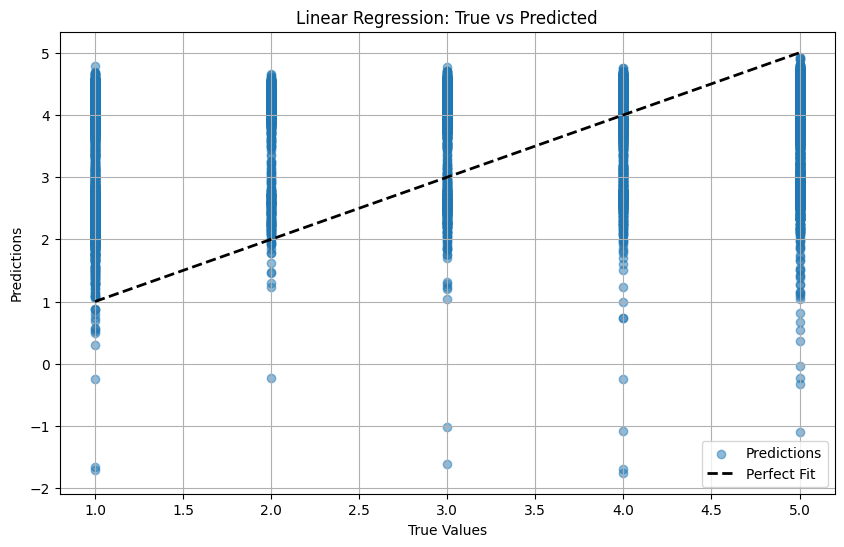

In [333]:
from sklearn.linear_model  import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

model = LinearRegression()

model.fit(x_train, y_train)

y_pred = model.predict(x_test)

print(f"R² Score: {r2_score(y_test, y_pred):.3f}")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Fit')
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Linear Regression: True vs Predicted")
plt.legend()
plt.grid(True)
plt.show()

Al tener algunas variables correlacionadas, debemos depurar las variables que incluimos dentro del modelo

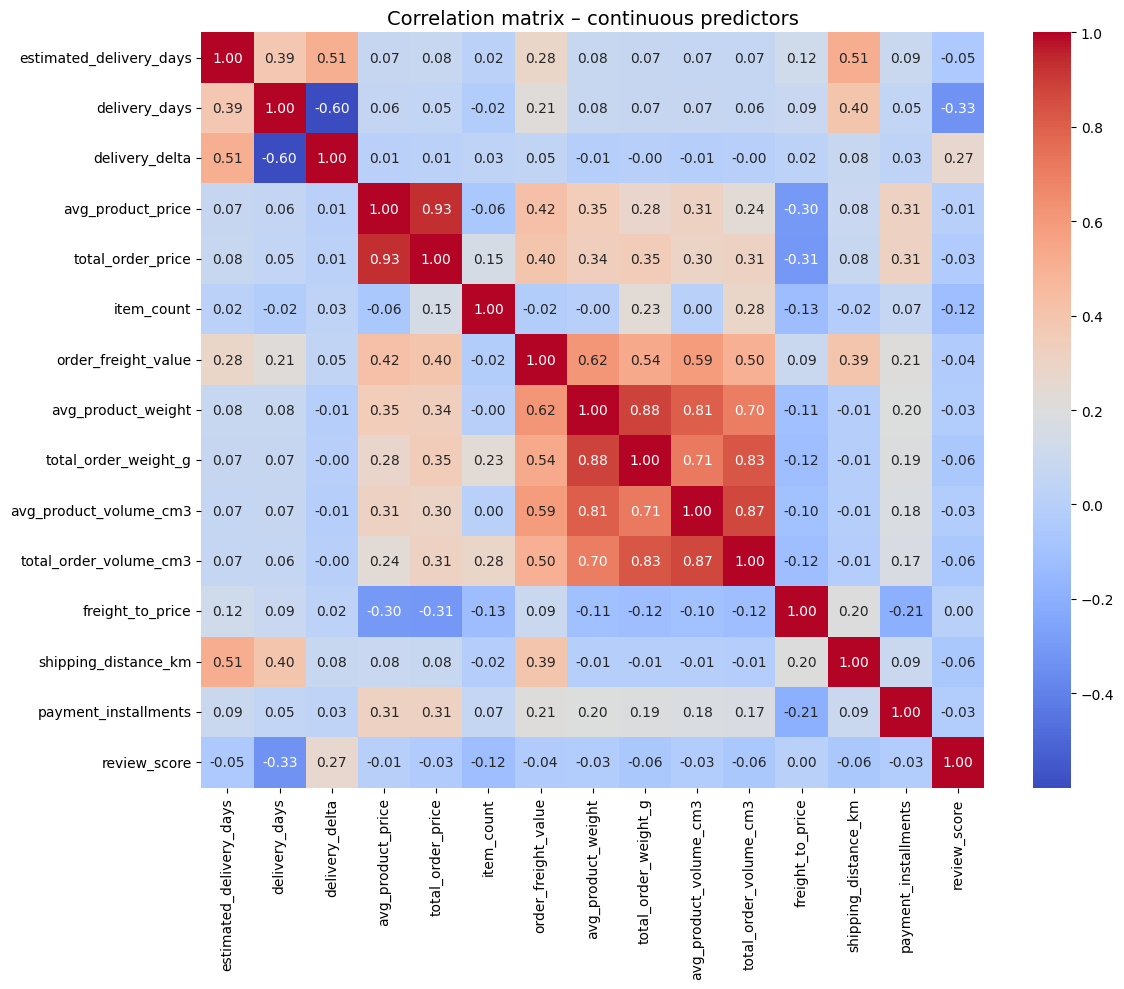

In [334]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns


cont_cols = [
    c for c in df.select_dtypes(include=[np.number]).columns
    if (df[c].nunique() >= 3) and c != 'review_score'
]

df_cont = df[cont_cols + ['review_score']].dropna()

corr = df_cont.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f',
            xticklabels=corr.columns, yticklabels=corr.columns)
plt.title('Correlation matrix – continuous predictors', fontsize=14)
plt.tight_layout()
plt.show()

En la matriz de correlación anterior podemos observar que hay algunas variables que tienen correlación con review_score. Pero también podemos ver que hay regresores que tienen alta colinealidad entre ellos. Esto sugiere que el modelo debe ser depurado

In [335]:
X = df_cont.drop(columns=['review_score'])
y = df_cont['review_score']
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)


def backward_elimination(X, y, sl=0.05):
    feats = X.columns.tolist()
    while True:
        model = sm.OLS(y, sm.add_constant(X[feats])).fit()
        pvals = model.pvalues.drop('const')
        worst_p = pvals.max()
        if worst_p > sl:
            feats.remove(pvals.idxmax())
        else:
            return model, feats

be_model, sel_feats = backward_elimination(X_train, y_train)

print("\n=== Resumen del modelo depurado (sin dummies) ===\n")
print(be_model.summary())
print(f"\nVariables seleccionadas: {sel_feats}")

usecols = sel_feats + ['review_score']
clear_df = pd.read_csv('dataset/cleaned_orders.csv', usecols=usecols)


=== Resumen del modelo depurado (sin dummies) ===

                            OLS Regression Results                            
Dep. Variable:           review_score   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     1339.
Date:                Sun, 27 Apr 2025   Prob (F-statistic):               0.00
Time:                        23:42:10   Log-Likelihood:            -1.2068e+05
No. Observations:               75622   AIC:                         2.414e+05
Df Residuals:                   75612   BIC:                         2.415e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

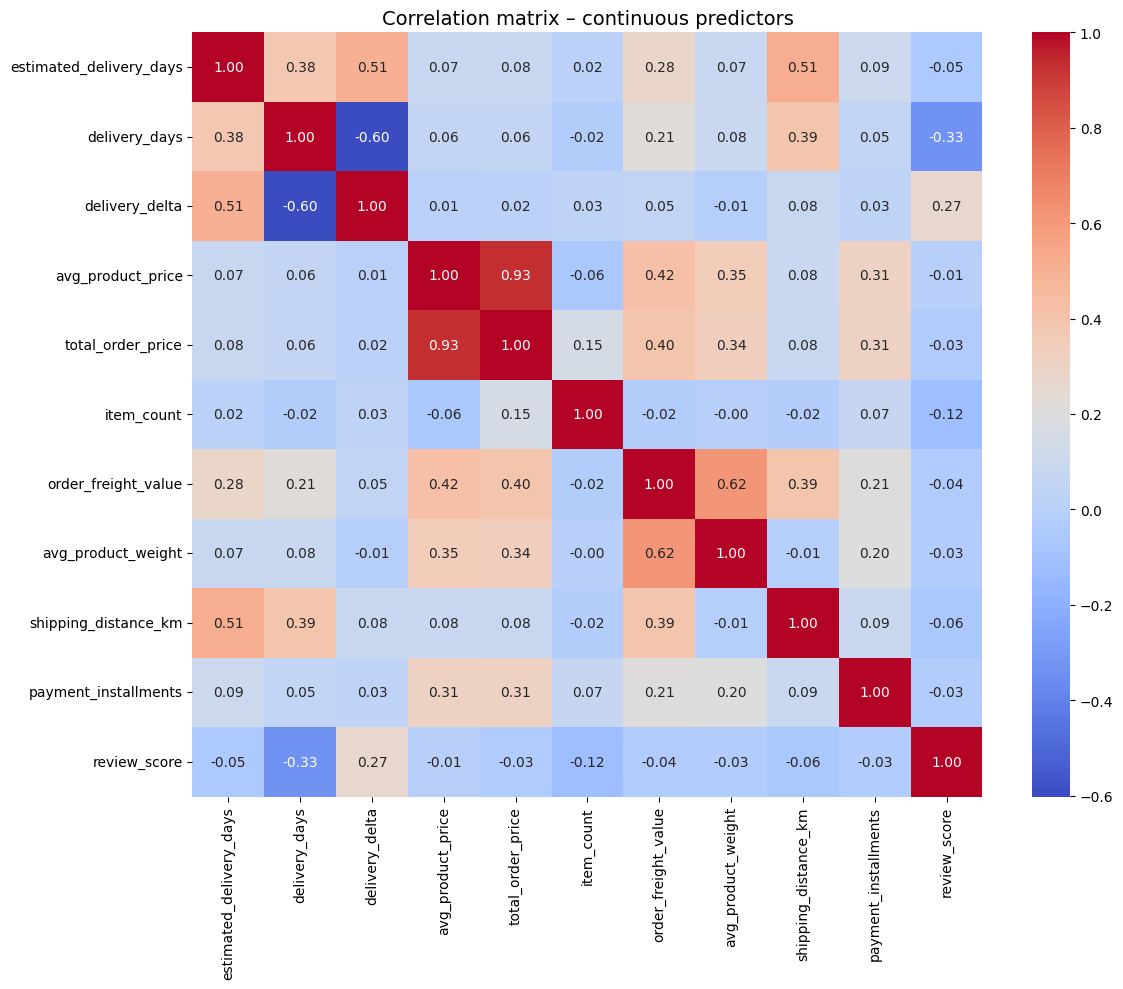

In [336]:
corr = clear_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=True, fmt='.2f',
            xticklabels=corr.columns, yticklabels=corr.columns)
plt.title('Correlation matrix – continuous predictors', fontsize=14)
plt.tight_layout()
plt.show()

Luego de depurar el modelo, podemos observar que se conservaron las clumnas estimated_delvery_days, delivery_days, delivery_delta, avg_product_price, total_order_price, item_count, order_freight_value, avg_product_weight, shipping_distance_km y payment_installments


RMSE hold‑out: 1.1827
R² hold‑out: 0.1433


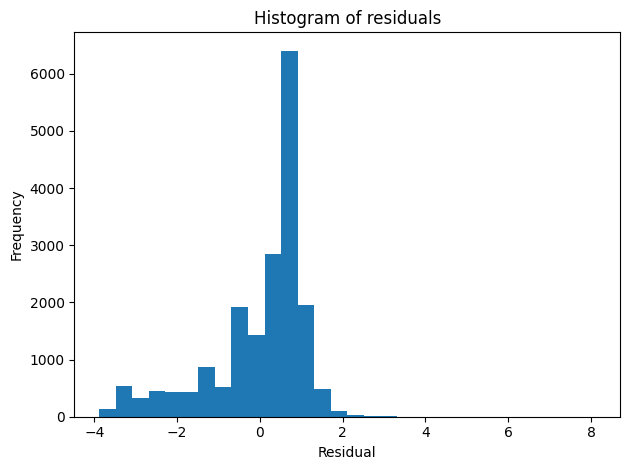

<Figure size 640x480 with 0 Axes>

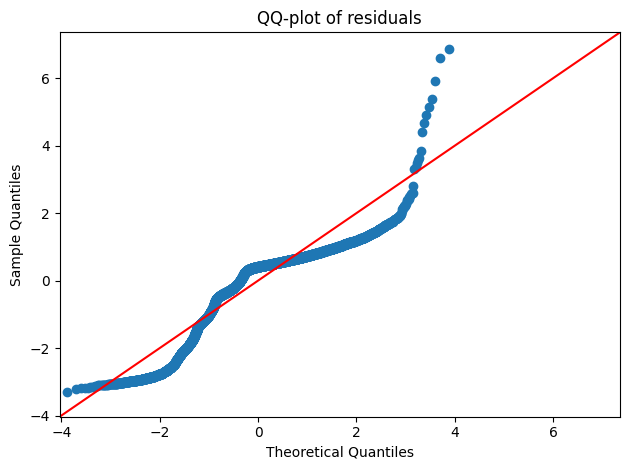

In [337]:
linreg = LinearRegression().fit(X_train[sel_feats], y_train)
y_pred = linreg.predict(X_test[sel_feats])
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print(f'\nRMSE hold‑out: {rmse:.4f}')
print(f'R² hold‑out: {r2:.4f}')

residuals = y_test - y_pred

# Histograma de residuales
plt.figure()
plt.hist(residuals, bins=30)
plt.title('Histogram of residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# QQ‑plot
plt.figure()
qqplot(residuals, line='45', fit=True)
plt.title('QQ‑plot of residuals')
plt.tight_layout()
plt.show()

Los errores están centrados en 0 (modelo no sesgado en promedio) pero la distribución es asimétrica y con colas gruesas (kurtosis > 0).

Las colas de la distribución empírica son más pesadas que las de una normal; se confirma la falta de normalidad.

In [338]:
params = be_model.params
intercept = params['const']
betas = params.drop('const')


eq = f"ŷ = {intercept:.4f}"
for var, coef in betas.items():
    sign = "+" if coef >= 0 else "-"
    eq += f" {sign} {abs(coef):.4f}·{var}"

print("Ecuación del modelo lineal:")
print(eq)

Ecuación del modelo lineal:
ŷ = 4.8121 - 0.0107·estimated_delivery_days - 0.0315·delivery_days + 0.0208·delivery_delta + 0.0003·avg_product_price - 0.0003·total_order_price - 0.2860·item_count + 0.0010·order_freight_value - 0.0000·avg_product_weight + 0.0001·shipping_distance_km - 0.0058·payment_installments


En la parte de arriba podemos observar la ecuación del modelo ya depurado el cual nos maximiza el R² a un 0.137 y un adj-R² de 0.137 de igual forma

## Random Forest

Para implementar este modelo de regresion, primero vamos a elegir algunos valores iniciales para cada una de las regresiones que vamos a realizar. Luego, vamos a interpretar estos valores iniciales para intentar explicar ciertos comportamientos y predecir la influencia de valores mas optimos. Por ultimo, vamos a utilizar GridSearch para encontrar los valores optimos y analizar el rendimiento de este modelo optimizado

### Satisfaccion del Cliente

Importamos el regresor de random forest, creamos los splits X e Y tanto para prueba como para entrenamiento y entrenamos nuestro modelo inicial.

Evaluación del Modelo Random Forest:
Mean Squared Error (MSE): 1.299714
Mean Absolute Error (MAE): 0.878826
R-squared (R²): 0.211249


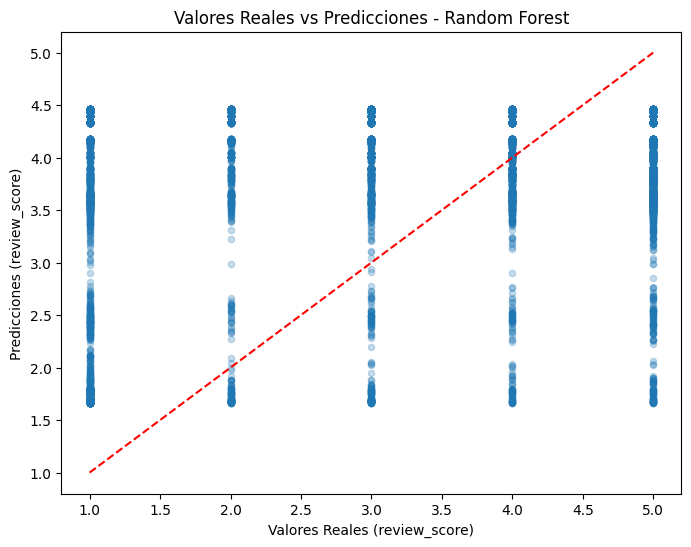

In [339]:
from sklearn.ensemble import RandomForestRegressor

# Separacion X / Y train
x_train = dftrain.drop(columns=['review_score'])
y_train = dftrain['review_score']

# Separacion X / Y test
x_test = dftest.drop(columns=['review_score'])
y_test = dftest['review_score']

# Creacion de modelo
rf_regressor = RandomForestRegressor(n_estimators=100, random_state = 42, max_depth = 4)

# Entrenamiento de modelo
rf_regressor.fit(x_train, y_train)

# Predicciones con el modelo
y_pred = rf_regressor.predict(x_test)

# Estadisticas de rendimiento
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir estadisticas
print("Evaluación del Modelo Random Forest:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²): {r2:.6f}")

# Plot reales vs esperados
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.25, s=20)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--')
plt.xlabel("Valores Reales (review_score)")
plt.ylabel("Predicciones (review_score)")
plt.title("Valores Reales vs Predicciones - Random Forest")
plt.show()

Podemos observar que el modelo no parece ser muy preciso, tiene un R2 de 0.21 y dentro de la grafica podemos ver que el trendline parece seguir un patron completamente diferente. Ademas, el modelo nunca predijo un review_score menor a 1.5, esto nos puede indicar que la distribucion que sigue la variable respuesta puede tener una distribucion con muy pocos valores bajos. A continuacion, vamos a realizar un Gridsearch para intentar tener un modelo con un mejor rendimiento.


Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

Evaluación del Modelo Random Forest Optimizado:
Mean Squared Error (MSE): 1.294447
Mean Absolute Error (MAE): 0.872987
R-squared (R²): 0.214446


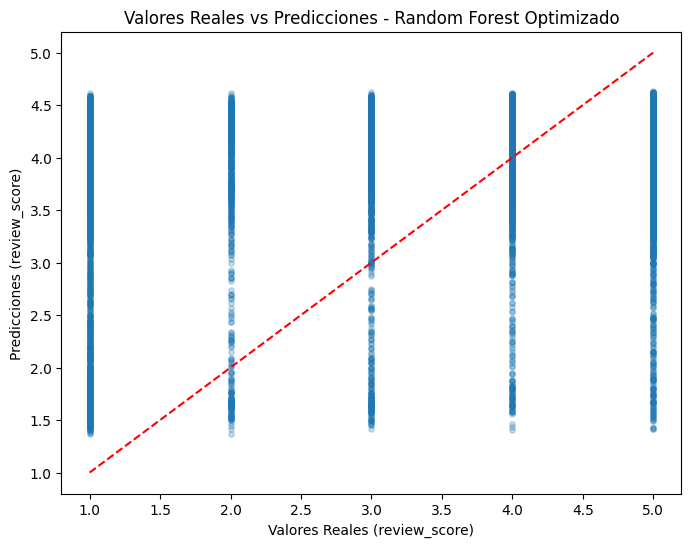

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

param_grid = {
    'n_estimators': [100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
}

rf_regressor = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=rf_regressor,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nBest Parameters:", grid_search.best_params_)
print("\nEvaluación del Modelo Random Forest Optimizado:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²): {r2:.6f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.25, s=15)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--')
plt.xlabel("Valores Reales (review_score)")
plt.ylabel("Predicciones (review_score)")
plt.title("Valores Reales vs Predicciones - Random Forest Optimizado")
plt.show()

Al observar el rendimiento de este modelo, nos damos cuenta que los valores iniciales utilizados fueron bastante precisos. Al realizar el gridsearch con diferentes valores de profundidad, nos damos cuenta que nuestra hipotesis anterior sobre el modelo necesitando mas detalle era incorrecta. En este caso, el modelo mas efectivo encontrado resulto siendo en max_depth = 10, el valor inferior establecido. Observando nuevamente el modelo, podemos concluir que el 'problema' se encuentra con la distribucion de la variable objetivo. Ya que la mayoria de reviews se encuentra alrededor de 4 o 5 puntos el modelo suele predecirlas de manera mas precisa. Esto tambien lleva a que haga 'overshoot' con las variables inferiores. Donde en la grafica podemos observar un valor predecido de 3-5 para valores reales de 2 por ejemplo.

10 Features mas importantes:
                    Feature  Importance
2            delivery_delta    0.602647
6                item_count    0.076628
1             delivery_days    0.066091
13     shipping_distance_km    0.038525
7       order_freight_value    0.029192
12         freight_to_price    0.025000
0   estimated_delivery_days    0.023496
10   avg_product_volume_cm3    0.017138
11   total_order_volume_cm3    0.016768
4         avg_product_price    0.015765


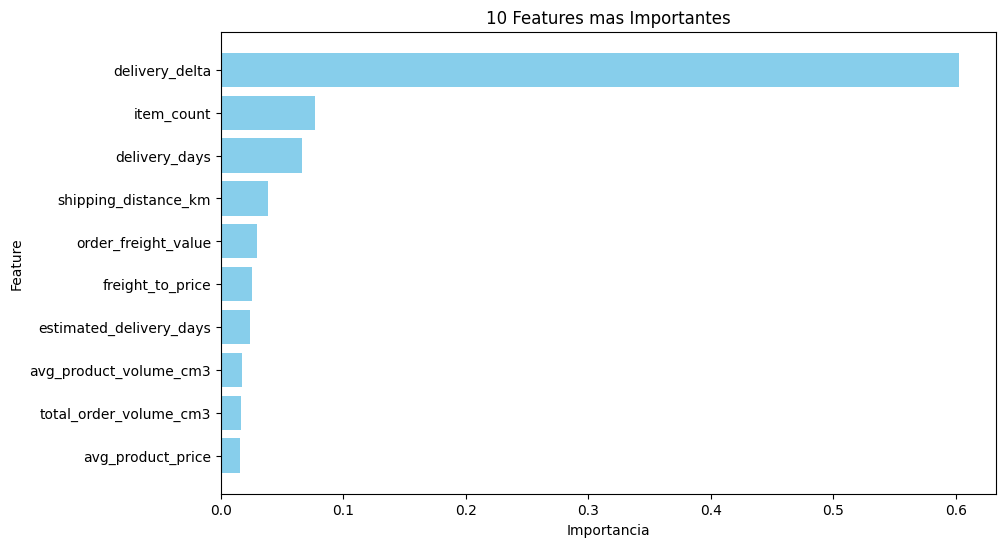

In [341]:
feature_importances = best_rf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("10 Features mas importantes:")
print(importance_df.head(10))

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Feature')
plt.title('10 Features mas Importantes')
plt.gca().invert_yaxis()
plt.show()

En cuanto a los features mas importantes, el modelo nos indica que entre los factores mas importantes relacionados a la experiencia del cliente se encuentra del 'delivery_delta'. Esta variable nos indica que tantos dias luego (o antes) de la fecha de entrega estimada fue entregado el pedido.

### Delivery Days

Importamos el regresor de random forest, creamos los splits X e Y tanto para prueba como para entrenamiento y entrenamos nuestro modelo inicial.

Evaluación del Modelo Random Forest:
Mean Squared Error (MSE): 70.416421
Mean Absolute Error (MAE): 5.357163
R-squared (R²): 0.211562


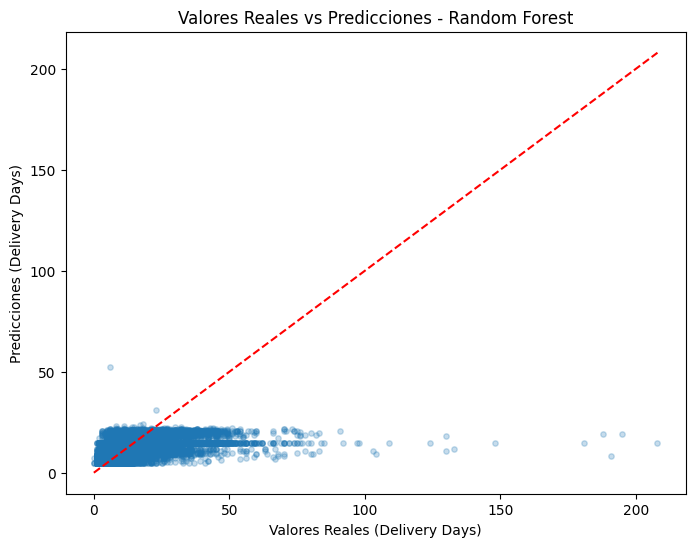

In [342]:
# Separacion X / Y train
x_train = dftrain_d.drop(columns=['delivery_days'])
y_train = dftrain_d['delivery_days']

# Separacion X / Y test
x_test = dftest_d.drop(columns=['delivery_days'])
y_test = dftest_d['delivery_days']

# Creacion de modelo
rf_regressor = RandomForestRegressor(n_estimators=100, random_state = 42, max_depth = 4)

# Entrenamiento del modelo
rf_regressor.fit(x_train, y_train)

# Predicciones con el modelo
y_pred = rf_regressor.predict(x_test)

# Estadisticas de rendimiento
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Evaluación del Modelo Random Forest:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²): {r2:.6f}")

#Plot de resultados
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.25, s=15)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel("Valores Reales (Delivery Days)")
plt.ylabel("Predicciones (Delivery Days)")
plt.title("Valores Reales vs Predicciones - Random Forest")
plt.show()

Este modelo parece tener un rendimiento bastante pobre, segun la grafica el modelo falla en predecir correctamente valores mas altos. Esto se debe en parte a que son valores atipicos, como lo puede ser un delivery de 200+ dias. Sin embargo, observamos que no logra captar correctamente en trend desde un principio y parece mas que todo seguir una linea horizontal. Posiblemente con un parametro de profundidad mas alto se obtengan mejores resultados. Esto tambien se evidencia de cierta manera por la structura de la grafica, donde parece predecir algunos valores con una frecuencia demasiado alta generando una linea horizontal recta.


Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}

Evaluación del Modelo Random Forest Optimizado:
Mean Squared Error (MSE): 67.843524
Mean Absolute Error (MAE): 5.209530
R-squared (R²): 0.240370


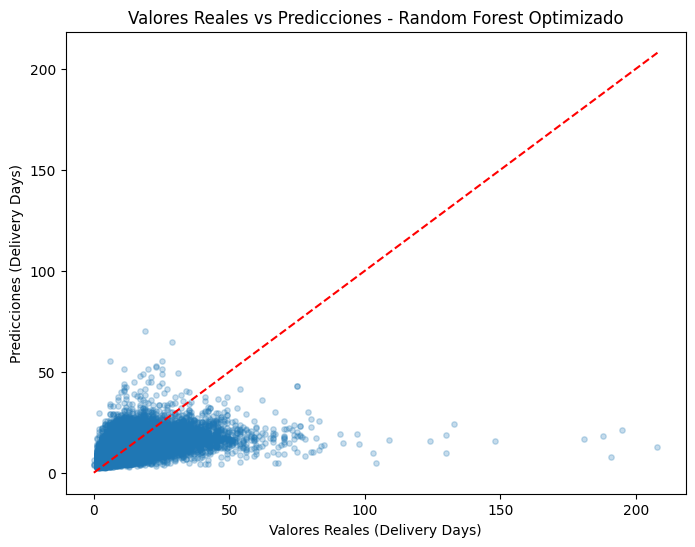

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

param_grid = {
    'n_estimators': [100],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

rf_regressor = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=rf_regressor,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid_search.fit(x_train, y_train)

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(x_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nBest Parameters:", grid_search.best_params_)
print("\nEvaluación del Modelo Random Forest Optimizado:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R²): {r2:.6f}")

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.25, s=15)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--')
plt.xlabel("Valores Reales (Delivery Days)")
plt.ylabel("Predicciones (Delivery Days)")
plt.title("Valores Reales vs Predicciones - Random Forest Optimizado")
plt.show()

Luego de hacer un gridsearch con parametros de profundidad mas altos, logramos obtener un r2 de 0.24. Este valor es significativamente mayor al de la regresion anterior, ademas la grafica parece hacer predicciones mas variadas en vez de apegarse unicamente a ciertos valores. Esto nos indica que esta categorizando de una mejor manera los valores. Sin embargo, seguimos viendo problemas con valores mas altos (outliers) que nuestro modelo no logra predecir precisamente.

10 Features mas importantes:
                   Feature  Importance
9     shipping_distance_km    0.198148
10         different_state    0.190757
3      order_freight_value    0.103665
8         freight_to_price    0.064604
6   avg_product_volume_cm3    0.060493
7   total_order_volume_cm3    0.053279
0        avg_product_price    0.053129
4       avg_product_weight    0.048326
1        total_order_price    0.044989
5     total_order_weight_g    0.043666


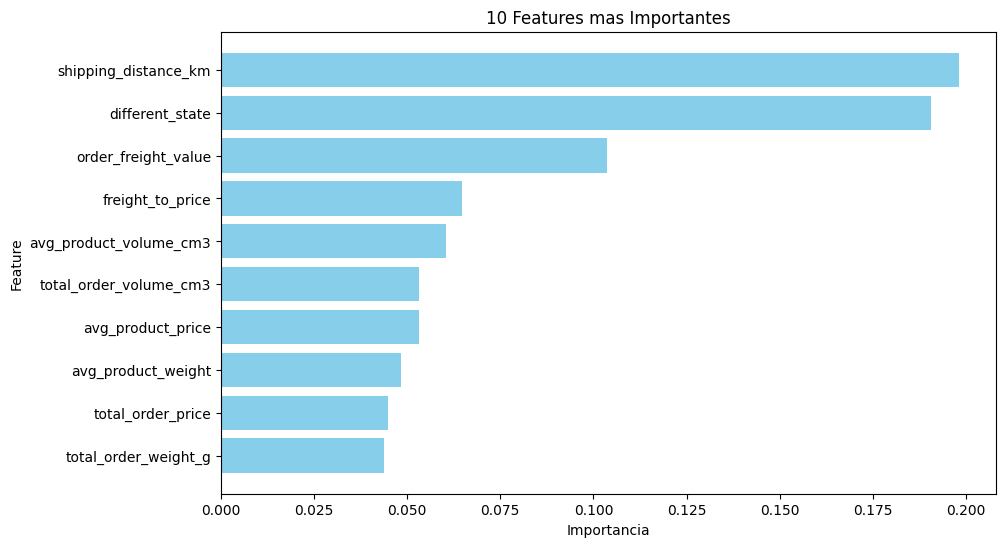

In [344]:
feature_importances = best_rf.feature_importances_

importance_df = pd.DataFrame({
    'Feature': x_train.columns,
    'Importance': feature_importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("10 Features mas importantes:")
print(importance_df.head(10))

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'][:10], importance_df['Importance'][:10], color='skyblue')
plt.xlabel('Importancia')
plt.ylabel('Feature')
plt.title('10 Features mas Importantes')
plt.gca().invert_yaxis()
plt.show()

Esta grafica nos indica que dentro de los features mas importantes, se encuentra la distancia y el hecho que el cliente y el vendedor se encuentren en estados diferentes. Luego, algunas demas variables como volumen y peso del producto suelen afectar el tiempo del delivery tambien. Al momento de realizar modelos de clasificacion, podemos contrastar esta informacion con la clasificacion de 'delivery delayed' donde veremos si estos factores afectan el atraso de los deliveries o unicamente aumentan el tiempo.

## KNN

Para implementar este modelo de regresion, primero vamos a elegir algunos valores iniciales para cada una de las regresiones que vamos a realizar. Luego, vamos a interpretar estos valores iniciales para intentar explicar ciertos comportamientos y predecir la influencia de valores mas optimos. Por ultimo, vamos a utilizar GridSearch para encontrar los valores optimos y analizar el rendimiento de este modelo optimizado.

### Satisfaccion del Cliente

Importamos el regresor de KNN, creamos los splits X e Y tanto para prueba como para entrenamiento, escalamos nuestros conjuntos X y entrenamos el modelo.

In [345]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train = dftrain.drop(columns=['review_score'])

y_train = dftrain['review_score']

x_test = dftest.drop(columns=['review_score'])
y_test = dftest['review_score']

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Resultados KNN Regression:
MAE  = 0.92
RMSE = 1.26
R²   = 0.0419


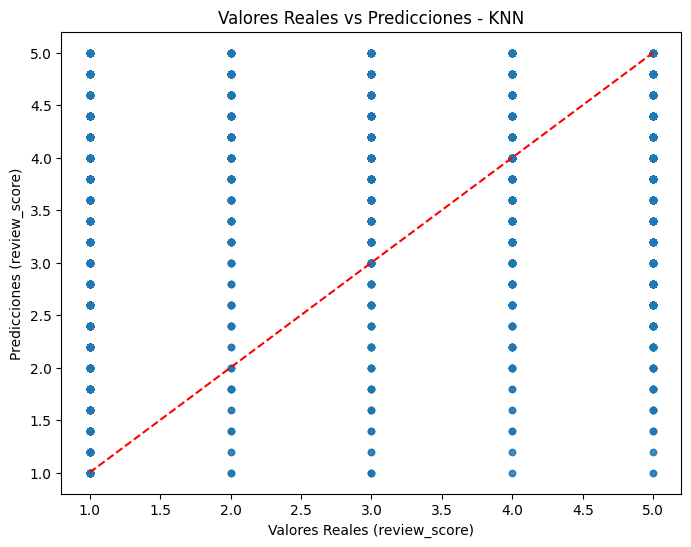

In [346]:
from sklearn.neighbors import KNeighborsRegressor

# Crear el modelo KNN
knn_model = KNeighborsRegressor(n_neighbors=5) 
knn_model.fit(x_train, y_train)

# Predicciones
y_pred = knn_model.predict(x_test)

# Evaluación
mae_knn = mean_absolute_error(y_test, y_pred)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_knn = r2_score(y_test, y_pred)

print(f"Resultados KNN Regression:")
print(f"MAE  = {mae_knn:.2f}")
print(f"RMSE = {rmse_knn:.2f}")
print(f"R²   = {r2_knn:.4f}")

# Plot reales vs esperados
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.25, s=20)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--')
plt.xlabel("Valores Reales (review_score)")
plt.ylabel("Predicciones (review_score)")
plt.title("Valores Reales vs Predicciones - KNN")
plt.show()

Este modelo de KNN tiene un r2 de 0.04, ademas dentro de la grafica podemos observar que no parece seguir algun trend. No parece tener capacidad alguna de realizar predicciones, esto puede deberse a correlaciones debiles entre los datos. Por lo cual vamos a aumentar el parametro de n_neighbors significativamente en nuestra busqueda de optimizacion de parametros

Best parameters: {'n_neighbors': 19, 'p': 1}
Resultados KNN Regression (Best Model):
MAE  = 0.89
RMSE = 1.18
R²   = 0.1516


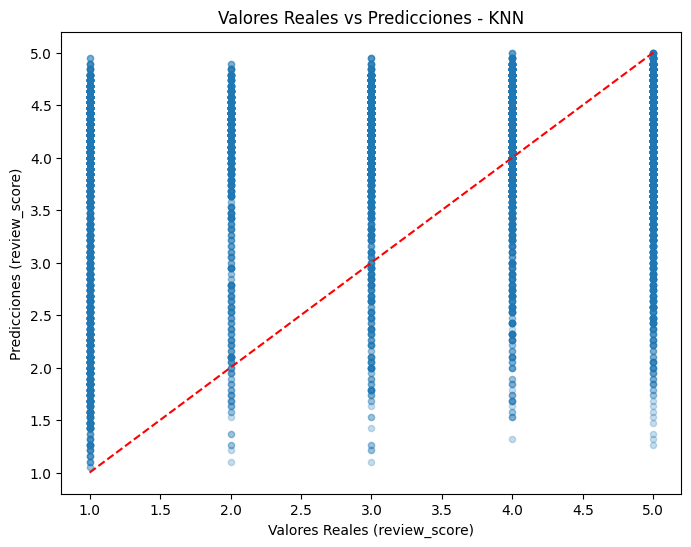

In [347]:
param_grid = {
    'n_neighbors': [11, 13, 15, 17, 19],
    'p': [1,2]
}

 # Crear el regresor KNN
knn = KNeighborsRegressor()
 

 # Crear el GridSearch
grid_search = GridSearchCV(
  knn, param_grid, cv=5, scoring='r2'
 )

grid_search.fit(x_train, y_train)
 

 # Obtener los mejores parametros
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")
 

 # Get el mejor modelo
best_knn = grid_search.best_estimator_
 

 # Predecir utilizando el mejor  modelo
y_pred = best_knn.predict(x_test)
 

 # Metricas de rendimiento
mae_knn = mean_absolute_error(y_test, y_pred)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_knn = r2_score(y_test, y_pred)
 

print(f"Resultados KNN Regression (Best Model):")
print(f"MAE  = {mae_knn:.2f}")
print(f"RMSE = {rmse_knn:.2f}")
print(f"R²   = {r2_knn:.4f}")

# Plot reales vs esperados
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.25, s=20)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--')
plt.xlabel("Valores Reales (review_score)")
plt.ylabel("Predicciones (review_score)")
plt.title("Valores Reales vs Predicciones - KNN")
plt.show()

Luego de optimizar los parametros, logramos obtener un R^2 mayor. Dentro de los modelos analizados con los parametros indicados, el mejor puntaje se obtuvo en el limite superior. Esto nos indica que el numero de n_neighbors puede aumentarse para obtener mejores resultados y evitar los problemas que encontramos el modelo anterior.

### Delivery Days

In [348]:
x_train = dftrain_d.drop(columns=['delivery_days'])
y_train = dftrain_d['delivery_days']

x_test = dftest_d.drop(columns=['delivery_days'])
y_test = dftest_d['delivery_days']

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Resultados KNN Regression:
MAE  = 5.74 días
RMSE = 8.96 días
R²   = 0.1001


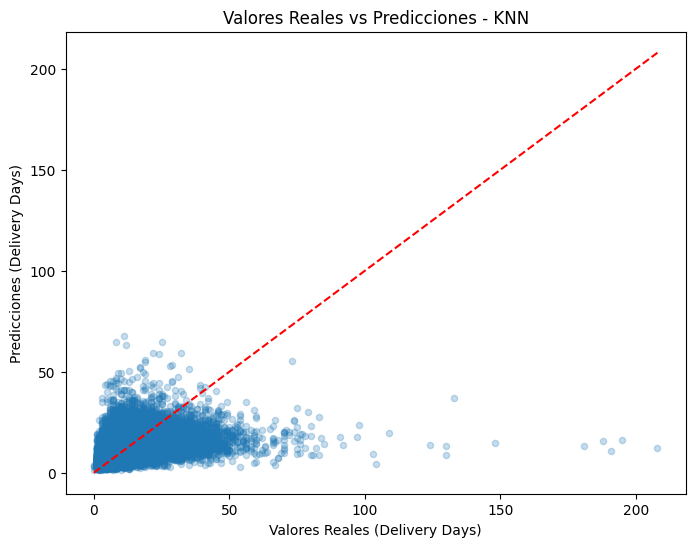

In [349]:
# Crear el modelo KNN
knn_model = KNeighborsRegressor(n_neighbors=5) 
knn_model.fit(x_train, y_train)

# Predicciones
y_pred = knn_model.predict(x_test)

# Evaluación
mae_knn = mean_absolute_error(y_test, y_pred)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_knn = r2_score(y_test, y_pred)

print(f"Resultados KNN Regression:")
print(f"MAE  = {mae_knn:.2f} días")
print(f"RMSE = {rmse_knn:.2f} días")
print(f"R²   = {r2_knn:.4f}")

# Plot reales vs esperados
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.25, s=20)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--')
plt.xlabel("Valores Reales (Delivery Days)")
plt.ylabel("Predicciones (Delivery Days)")
plt.title("Valores Reales vs Predicciones - KNN")
plt.show()

In [ ]:
param_grid = {
    'n_neighbors': [9, 11, 13, 15, 17],
    'p': [1,2]
}

 # Create the KNN Regressor
knn = KNeighborsRegressor()
 

 # Create the GridSearchCV object
grid_search = GridSearchCV(
  knn, param_grid, cv=5, scoring='neg_mean_absolute_error'
 )  # cv=5 means 5-fold cross-validation
 

 # Fit the GridSearchCV object to the training data
grid_search.fit(x_train, y_train)
 

 # Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")
 

 # Get the best model
best_knn = grid_search.best_estimator_
 

 # Make predictions on the test set using the best model
y_pred_knn = best_knn.predict(x_test)
 

 # Evaluate the best model
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)
 

print(f"Resultados KNN Regression (Best Model):")
print(f"MAE  = {mae_knn:.2f} días")
print(f"RMSE = {rmse_knn:.2f} días")
print(f"R²   = {r2_knn:.4f}")

Best parameters: {'n_neighbors': 17, 'p': 1}
Resultados KNN Regression (Best Model):
MAE  = 0.90 días
RMSE = 1.19 días
R²   = 0.1460


Este modelo inicial tuvo un R^2 de 0.1, lo cual es bastante pobre. Sufre de las mismas debilidades que algunos modelos anteriores, donde los valores mas altos son sumamente dificiles de predecir para el modelo. Algunos de los outliers pueden ser imposibles de predecir, sin embargo desde antes observamos un trend que no es capaz de predecir por ejemplo valores de 50 dias que no tienen una muestra tan reducida.

Best parameters: {'n_neighbors': 19, 'p': 1}
Resultados KNN Regression (Best Model):
MAE  = 5.36
RMSE = 8.42
R²   = 0.2061


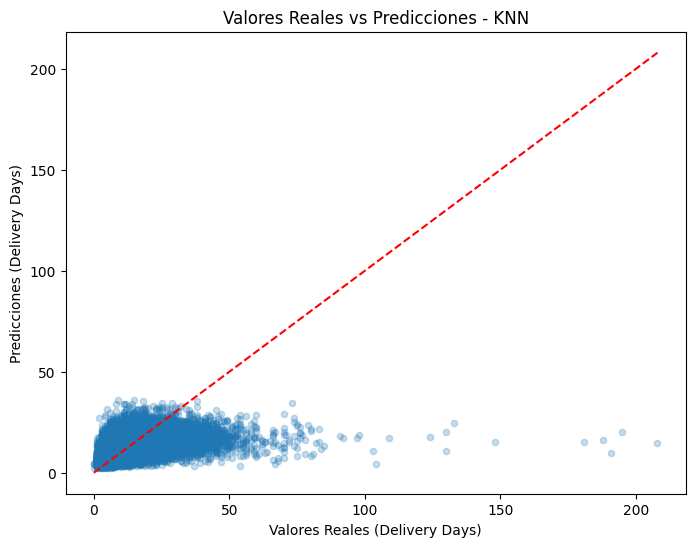

In [350]:
param_grid = {
    'n_neighbors': [11, 13, 15, 17, 19],
    'p': [1,2]
}

 # Crear el regresor KNN
knn = KNeighborsRegressor()
 

 # Crear el GridSearch
grid_search = GridSearchCV(
  knn, param_grid, cv=5, scoring='r2'
 )

grid_search.fit(x_train, y_train)
 

 # Obtener los mejores parametros
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")
 

 # Get el mejor modelo
best_knn = grid_search.best_estimator_
 

 # Predecir utilizando el mejor  modelo
y_pred = best_knn.predict(x_test)
 

 # Metricas de rendimiento
mae_knn = mean_absolute_error(y_test, y_pred)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred))
r2_knn = r2_score(y_test, y_pred)
 

print(f"Resultados KNN Regression (Best Model):")
print(f"MAE  = {mae_knn:.2f}")
print(f"RMSE = {rmse_knn:.2f}")
print(f"R²   = {r2_knn:.4f}")

# Plot reales vs esperados
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.25, s=20)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--')
plt.xlabel("Valores Reales (Delivery Days)")
plt.ylabel("Predicciones (Delivery Days)")
plt.title("Valores Reales vs Predicciones - KNN")
plt.show()

Luego del gridsearch, logramos encontrar los mejores parametros en el limite superior de n_neighbors. Esto nos quiere decir que aumentar este parametro tuvo efectos positivos, lo cual se confirma por medio de un R^2 de 0.2. Este modelo, en comparacion al anterior parece captar el trend correctamente por una mayor distancia del lado izquierdo de la grafica. Sin embargo, sigue encontrando limitaciones y no ha probado ser el modelo mas eficiente.

## SVR

### Customer Satisfaction

In [351]:
x_train = dftrain.drop(columns=['review_score'])
y_train = dftrain['review_score']

x_test = dftest.drop(columns=['review_score'])
y_test = dftest['review_score']

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Exception ignored in: <function ResourceTracker.__del__ at 0x79084ce6d080>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x754da5975080>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x74a531e7d080>
Traceback (most recent call last):
  File "/usr/lib/python3.13/multiprocessing/reso

KeyboardInterrupt: 

Resultados SVR (con muestreo de 5000 registros):
MAE  = 0.82 días
RMSE = 1.23 días
R²   = 0.0744


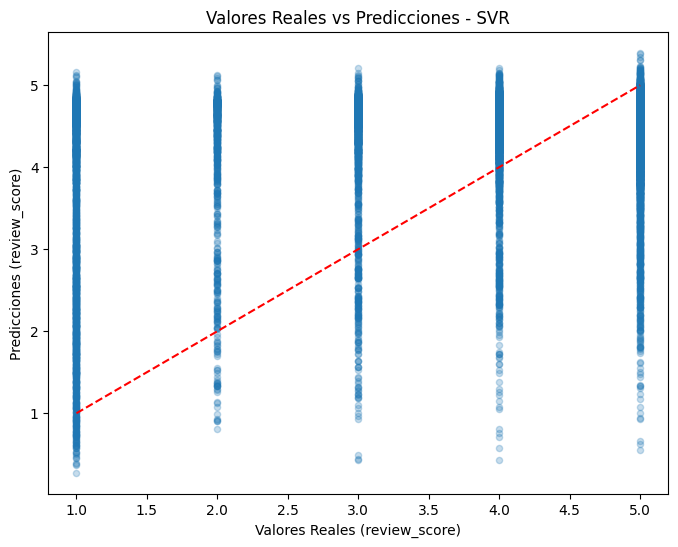

In [352]:
from sklearn.svm import SVR
from sklearn.utils import resample

# 1. Aplicar muestreo al set de entrenamiento
X_train_sample, y_train_sample = resample(x_train, y_train, n_samples=5000, random_state=42)


# 3. Predicciones (usamos el test completo para evaluar)
y_pred = svr_model.predict(x_test)

# 4. Evaluación
mae_svr = mean_absolute_error(y_test, y_pred)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred))
r2_svr = r2_score(y_test, y_pred)

print(f"Resultados SVR (con muestreo de 5000 registros):")
print(f"MAE  = {mae_svr:.2f} días")
print(f"RMSE = {rmse_svr:.2f} días")
print(f"R²   = {r2_svr:.4f}")

# Plot reales vs esperados
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.25, s=20)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--')
plt.xlabel("Valores Reales (review_score)")
plt.ylabel("Predicciones (review_score)")
plt.title("Valores Reales vs Predicciones - SVR")
plt.show()

Este modelo cuenta con un R2 de 0.07, esto nos indica un bajo rendimiento. Adicionalmente, podemos observar en la grafica que parece incapaz de encontrar relacion alguna entre las variables de entrada y la variable respuesta. Por ejemplo, para review score 1 tiene valores uniformemente distribuidos entre 1-5 y no parece tener alguna idea. Al no poder captar estas relaciones, tenemos una  indicacion que el modelo se encuentra underfitted y necesita un C como parametro mas alto


Best parameters: {'svr__C': 10, 'svr__epsilon': 0.4, 'svr__gamma': 'scale'}
Resultados SVR (Best Model):
MAE  = 0.88
RMSE = 1.22
R²   = 0.0965


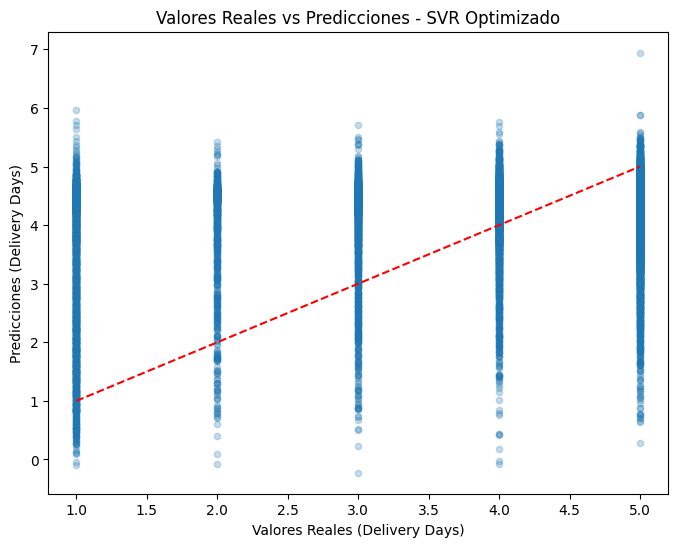

In [353]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
X_train_sample, y_train_sample = resample(
  x_train, y_train, n_samples=5000, random_state=42
 )

param_grid = {
  'svr__C': [0.1, 10],
  'svr__epsilon': [0.4],
  'svr__gamma': ['scale'],
}
 

pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('svr', SVR(kernel='rbf'))
 ])
 

grid_search = GridSearchCV(
  pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1
 ) 
grid_search.fit(X_train_sample, y_train_sample)

best_svr = grid_search.best_estimator_
y_pred = best_svr.predict(x_test)
 
mae_svr = mean_absolute_error(y_test, y_pred)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred))
r2_svr = r2_score(y_test, y_pred)
 

print("\nBest parameters:", grid_search.best_params_)
print(f"Resultados SVR (Best Model):")
print(f"MAE  = {mae_svr:.2f}")
print(f"RMSE = {rmse_svr:.2f}")
print(f"R²   = {r2_svr:.4f}")

# Plot reales vs esperados
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.25, s=20)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--')
plt.xlabel("Valores Reales (Delivery Days)")
plt.ylabel("Predicciones (Delivery Days)")
plt.title("Valores Reales vs Predicciones - SVR Optimizado")
plt.show()

Luego de la optimizacion, vemos una mejora ligera pero seguimos sin tener un  modelo que logre captar la relacion entre los datos. Esto nos indica que contamos con  una limitacion del conjunto de entrenamiento, donde el sample elegido no es suficiente. Sin embargo, debido a los requerimientos computacionales no nos resulta adecuado realizar un gridsearch con un set de entrenamiento mas amplio.

### Delivery Days

In [354]:
x_train = dftrain_d.drop(columns=['delivery_days'])
y_train = dftrain_d['delivery_days']

x_test = dftest_d.drop(columns=['delivery_days'])
y_test = dftest_d['delivery_days']

x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Resultados SVR (con muestreo de 5000 registros):
MAE  = 5.14 días
RMSE = 8.64 días
R²   = 0.1642


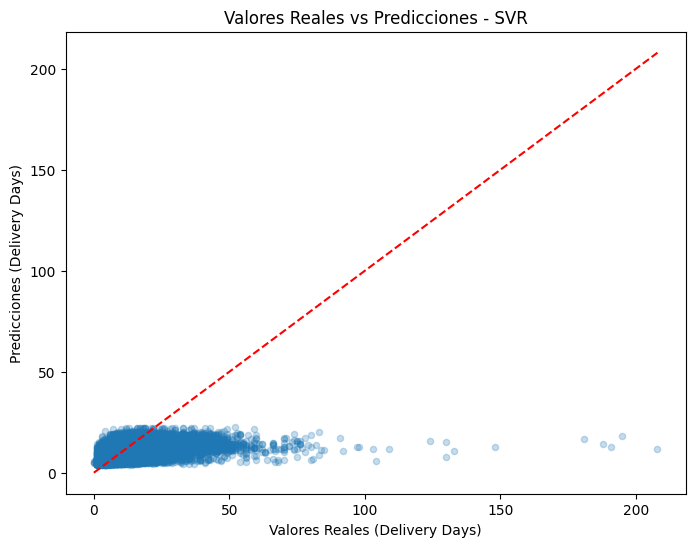

In [355]:
from sklearn.svm import SVR
from sklearn.utils import resample

# 1. Aplicar muestreo al set de entrenamiento
X_train_sample, y_train_sample = resample(x_train, y_train, n_samples=5000, random_state=42)

# 2. Crear el modelo SVR
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.2)
svr_model.fit(X_train_sample, y_train_sample)

# 3. Predicciones (usamos el test completo para evaluar)
y_pred = svr_model.predict(x_test)

# 4. Evaluación
mae_svr = mean_absolute_error(y_test, y_pred)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred))
r2_svr = r2_score(y_test, y_pred)

print(f"Resultados SVR (con muestreo de 5000 registros):")
print(f"MAE  = {mae_svr:.2f} días")
print(f"RMSE = {rmse_svr:.2f} días")
print(f"R²   = {r2_svr:.4f}")

# Plot reales vs esperados
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.25, s=20)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--')
plt.xlabel("Valores Reales (Delivery Days)")
plt.ylabel("Predicciones (Delivery Days)")
plt.title("Valores Reales vs Predicciones - SVR")
plt.show()

Similar al inciso anterior, pareciera que el modelo esta underfitted y es demasiado simple. Parece no captar correctamente la correlacion donde los valores reales de 0-50 siguen una distribucion bastante similar. Esto nos lleva a realizar un gridsearch nuevamente con un parametro mas grande de C.


Best parameters: {'svr__C': 10, 'svr__epsilon': 0.1, 'svr__gamma': 'scale'}
Resultados SVR (Best Model):
MAE  = 5.18
RMSE = 8.63
R²   = 0.1669


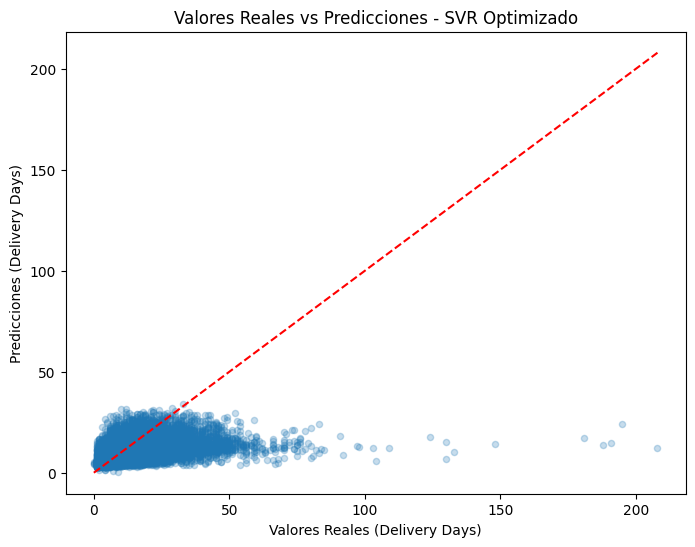

In [356]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
X_train_sample, y_train_sample = resample(
  x_train, y_train, n_samples=5000, random_state=42
 )

param_grid = {
  'svr__C': [0.1, 10],
  'svr__epsilon': [0.1],
  'svr__gamma': ['scale'],
}
 

pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('svr', SVR(kernel='rbf'))
 ])
 

grid_search = GridSearchCV(
  pipeline, param_grid, cv=3, scoring='r2', n_jobs=-1
 ) 
grid_search.fit(X_train_sample, y_train_sample)

best_svr = grid_search.best_estimator_
y_pred = best_svr.predict(x_test)
 
mae_svr = mean_absolute_error(y_test, y_pred)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred))
r2_svr = r2_score(y_test, y_pred)
 

print("\nBest parameters:", grid_search.best_params_)
print(f"Resultados SVR (Best Model):")
print(f"MAE  = {mae_svr:.2f}")
print(f"RMSE = {rmse_svr:.2f}")
print(f"R²   = {r2_svr:.4f}")

# Plot reales vs esperados
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.25, s=20)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 
         color='red', linestyle='--')
plt.xlabel("Valores Reales (Delivery Days)")
plt.ylabel("Predicciones (Delivery Days)")
plt.title("Valores Reales vs Predicciones - SVR Optimizado")
plt.show()


El modelo con el mejor rendimiento resulto ser el del parametro C mas alto, esto confirma que el tuning fue adecuado. En esta grafica, logramos observar como el modelo se adecua un poco mejor a los datos. Sin embargo, la mejora en R^2 fue bastante ligera.

## Rendimiento de los Modelos
En general todos los modelos compartian ciertas dificultades para realizar predicciones, entre ellas

- Los deliveries sumamente tardados son escasos, por lo que son dificiles de predecir.
- Los review scores se encuentran en su mayoria concentrados en 4-5.
- Debido al costo computacional, algunos modelos entrenaron con samples menos amplios como SVR

Esto llevo a la mayoria de modelos a tener rendimientos bajos, sin embargo dentro de las predicciones de delivery_days logramos captar trends en intervalos donde se encuentran la mayoria de los datos (0-50) y observar como afectaban los parametros. Luego, dentro de review_score logramos identificar como algunos parametros como por ejemplo profundidad del arbol o n_neighbors afectan las predicciones. Debido a la distribucion, este dataset nos dio un claro ejemplo de como un modelo 'superficial' (como un arbol con muy baja profundidad) puede predecir MUY incorrectamente (4's en vez de 1's, por ejemplo) debido a la distribucion de la variable objetivo.

## Modelos a Destacar

### Satisfaccion del Cliente

- Random Forest obtuvo el mejor R2 con un 0.2144, en comparacion a los demas que obtuvieron valores <0.15 consistentemente. En la grafica podemos observar que la gran mayoria de valores siguen siendo estimados como un 4+ (el valor mas prevalente, por mucho) pero empezamos a ver 'agujeros' en los valores intermedios entre el real y predecido. Es decir, en un valor real 2 puede que se prediga como 4 debido a la prevalencia de este puntaje pero es poco probable que se prediga como un 3.

### Delivery Days

- Random Forest obtuvo el mejor R2 con un 0.24, esta vez los demas modelos estuvieron cerca pero siguen teniendo un rendimiento inferior. En la grafica observamos como capta el trend inicial, sin embargo sigue teniendo problemas captando los valores mas altos igual que los demas modelos.

## Conclusiones

- La variacion de parametros nos ayudo a que nuestros modelos tuvieran un  mejor rendimiento para predecir las variables objetivo
- Las distribuciones de las variables objetivo pueden causar que los modelos tengan dificultades entendiendolas.
- Algunas relacionas son no lineales, por lo que la regresion lineal no tuvo el rendimiento que nosotros esperamos.
- Algunos modelos se ven altamente afectados por los parametros, ofreciendo un intercambio entre rendimiento y precision. Por ejemplo, KNN con numeros bajos fue muy poco preciso pero sumamente rapido. Al aumentar este numero, el gridsearch tuvo tiempos de ejecucion similares a Random Forest.